### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import masserstein

In [3]:
import os

from masserstein import Spectrum, NMRSpectrum
from masserstein import estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns
from textwrap import wrap

### Ground truth

In [4]:
protons = [10, 10, 8]

In [5]:
molar_proportions = [0.4855, 0.2427, 0.2718]

In [6]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.5134089082526119, 0.25665157988240767, 0.22993951186498032]

### Loading the data

In [7]:
official_names = ['Leucine', 'Isoleucine', 'Valine']

In [8]:
mix = np.loadtxt(os.getcwd()+'/BCAA_aligned.csv', skiprows=0, usecols=range(2), 
                      delimiter=',',dtype=float)
ppm = mix[:,0]
mix = mix[:,1]

comp = np.loadtxt(os.getcwd()+'/library_BCAA_aligned.csv', skiprows=1, usecols=range(4),
                      delimiter=',', dtype=float)
ppm_components = comp[:,0]
components = comp[:,1:]

In [9]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [10]:
spectra = []
for i, comp_ints in enumerate(components_ints):
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints)), protons=protons[i]))

In [11]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

<IPython.core.display.Javascript object>


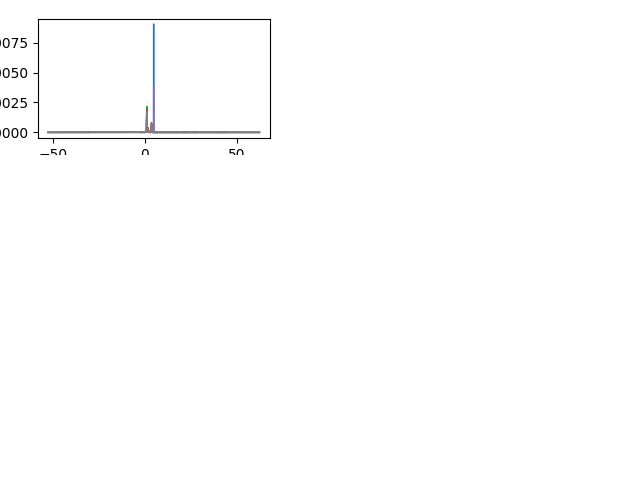

In [12]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)

### Alignment

In [13]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

### Preprocessing

In [14]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        return (min_of_min - epsilon)*(-1)
    else:
        return(0)

In [15]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [16]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [17]:
spectra_and_mixture = spectra + [mix]

In [18]:
shift_coef = shift(spectra_and_mixture)

In [19]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [20]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [21]:
cma = common_mass_axis(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [23]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [24]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [25]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [26]:
mix.plot(profile=True)
spectra[0].plot(profile=True)
spectra[1].plot(profile=True)
spectra[2].plot(profile=True)

### Removing unnecessary data points

In [27]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.NMRSpectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [28]:
#0.1, 4 without solvent peak
#0.1, 5.4
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 0.1, 4)

In [29]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [30]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [31]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [32]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [33]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [34]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [35]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [36]:
official_names

['Leucine', 'Isoleucine', 'Valine']

In [37]:
labels = official_names + ['Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


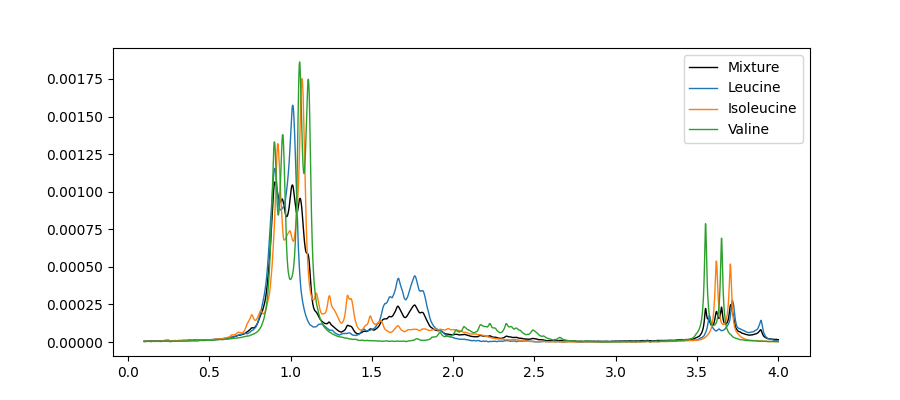

In [38]:
fig, ax = plt.subplots()
fig.set_size_inches(9, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True) 
ax.legend()

### Finding best kappa

In [49]:
import time
import pandas as pd
import pulp

In [50]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [45]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, spectra, 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False),
#                                     what_to_compare='area')
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2023-11-10


/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


Estimation for 0.01 and 0.01 done
It took: 2.839390993118286 seconds.
[0.5051788819040006, 0.24496670271500035, 0.2232254164600003]
Estimation for 0.01 and 0.02 done
It took: 2.8274569511413574 seconds.
[0.5020238314870007, 0.2370750572540003, 0.2277801681270003]
Estimation for 0.01 and 0.03 done
It took: 2.916125535964966 seconds.
[0.5001555036120007, 0.2386726470270003, 0.2248306077220003]
Estimation for 0.01 and 0.04 done
It took: 3.1747984886169434 seconds.
[0.4997722414660007, 0.2380277798250003, 0.22419786129300032]
Estimation for 0.01 and 0.05 done
It took: 3.354807138442993 seconds.
[0.5001335166560007, 0.2349590440030003, 0.2251706277350003]
Estimation for 0.01 and 0.060000000000000005 done
It took: 3.2396154403686523 seconds.
[0.5001335166560007, 0.2349590440030003, 0.2251706277350003]
Estimation for 0.01 and 0.06999999999999999 done
It took: 3.3372957706451416 seconds.
[0.5001335166560007, 0.2349590440030003, 0.2251706277350003]
Estimation for 0.01 and 0.08 done
It took: 3.1

Estimation for 0.03 and 0.01 done
It took: 2.677185535430908 seconds.
[0.5026129744590007, 0.24686264680100034, 0.23314131511700031]
Estimation for 0.03 and 0.02 done
It took: 2.7618510723114014 seconds.
[0.5026681926590006, 0.25001515986500034, 0.2247542497140003]
Estimation for 0.03 and 0.03 done
It took: 2.6953001022338867 seconds.
[0.5027860735520007, 0.24936105614500034, 0.2224742850650003]
Estimation for 0.03 and 0.04 done
It took: 2.7902679443359375 seconds.
[0.5027157815230007, 0.25055053867200033, 0.2190451453190003]
Estimation for 0.03 and 0.05 done
It took: 2.845797300338745 seconds.
[0.5028736163510007, 0.2506761199880003, 0.2178684222130003]
Estimation for 0.03 and 0.060000000000000005 done
It took: 2.8358943462371826 seconds.
[0.5028956617840007, 0.2508922952990003, 0.21678224642000027]
Estimation for 0.03 and 0.06999999999999999 done
It took: 2.8961498737335205 seconds.
[0.5030556882100007, 0.2514503236500003, 0.2151109286120003]
Estimation for 0.03 and 0.08 done
It took

Estimation for 0.05 and 0.01 done
It took: 2.929204225540161 seconds.
[0.49679199062400065, 0.24722816610800033, 0.24273574489700034]
Estimation for 0.05 and 0.02 done
It took: 2.875880718231201 seconds.
[0.5000760933010007, 0.24869542990700033, 0.2329253327520003]
Estimation for 0.05 and 0.03 done
It took: 2.7884597778320312 seconds.
[0.5006457753850007, 0.2524574716300003, 0.22512226618200032]
Estimation for 0.05 and 0.04 done
It took: 2.771531105041504 seconds.
[0.5022215631370006, 0.2531256512670003, 0.2211328610410003]
Estimation for 0.05 and 0.05 done
It took: 2.788902521133423 seconds.
[0.5035941926370007, 0.25447375410700035, 0.2170167712490003]
Estimation for 0.05 and 0.060000000000000005 done
It took: 2.950983762741089 seconds.
[0.5039926605230006, 0.25501369279500036, 0.21547157192200028]
Estimation for 0.05 and 0.06999999999999999 done
It took: 2.903454303741455 seconds.
[0.5043688707580006, 0.2552376192930003, 0.2143970845070003]
Estimation for 0.05 and 0.08 done
It took: 

Estimation for 0.060000000000000005 and 0.28 done
It took: 3.3238790035247803 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 3.5857346057891846 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
Estimation for 0.060000000000000005 and 0.3 done
It took: 3.590390205383301 seconds.
[0.5053356769780006, 0.25800448087900035, 0.2099479239120003]
Estimation for 0.06999999999999999 and 0.01 done
It took: 3.332434892654419 seconds.
[0.49890118422300067, 0.24263723847500032, 0.24670480930500033]
Estimation for 0.06999999999999999 and 0.02 done
It took: 3.0563228130340576 seconds.
[0.4977433878990007, 0.24860700856000034, 0.2385680411340003]
Estimation for 0.06999999999999999 and 0.03 done
It took: 2.984036922454834 seconds.
[0.4979754538180007, 0.25194998548300035, 0.2313007603960003]
Estimation for 0.06999999999999999 and 0.04 done
It took: 2.815143585205078 seconds.
[0.50059931

Estimation for 0.08 and 0.25 done
It took: 3.2068893909454346 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.08 and 0.26 done
It took: 3.2153804302215576 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.08 and 0.27 done
It took: 3.2832601070404053 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.08 and 0.28 done
It took: 3.1369287967681885 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.08 and 0.29000000000000004 done
It took: 3.2876482009887695 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.08 and 0.3 done
It took: 3.1496236324310303 seconds.
[0.5056000021190007, 0.2596814188040003, 0.2086976161890003]
Estimation for 0.09 and 0.01 done
It took: 3.9897360801696777 seconds.
[0.5086170751150006, 0.2327518060470003, 0.24800501514000034]
Estimation for 0.09 and 0.02 done
It took: 3.378483533859253 

Estimation for 0.09999999999999999 and 0.23 done
It took: 3.1975696086883545 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 3.170501708984375 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.25 done
It took: 3.2424445152282715 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.26 done
It took: 3.1975133419036865 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.27 done
It took: 3.2274792194366455 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.28 done
It took: 3.121811866760254 seconds.
[0.5061533723850007, 0.26057126060000035, 0.20805205119300027]
Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 3.1339375972747803 s

Estimation for 0.12 and 0.22 done
It took: 3.2829272747039795 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.23 done
It took: 3.448000907897949 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.24000000000000002 done
It took: 3.699655532836914 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.25 done
It took: 3.33396315574646 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.26 done
It took: 3.448033571243286 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.27 done
It took: 3.373650550842285 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.28 done
It took: 3.484501600265503 seconds.
[0.5072809997490006, 0.2607112121780003, 0.20732459012900029]
Estimation for 0.12 and 0.29000000000000004 done
It took: 3.4

Estimation for 0.14 and 0.22 done
It took: 3.4311158657073975 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.23 done
It took: 3.327819347381592 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.24000000000000002 done
It took: 3.334674835205078 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.25 done
It took: 3.274193048477173 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.26 done
It took: 3.3037610054016113 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.27 done
It took: 3.4181666374206543 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.28 done
It took: 3.2044332027435303 seconds.
[0.5079056637070006, 0.26065560678700034, 0.20689074617600028]
Estimation for 0.14 and 0.29000000000000004 done
I

Estimation for 0.16 and 0.19 done
It took: 3.333794593811035 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.2 done
It took: 3.443490982055664 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.21000000000000002 done
It took: 3.7292399406433105 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.22 done
It took: 3.4593939781188965 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.23 done
It took: 3.5237584114074707 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.24000000000000002 done
It took: 3.866133213043213 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.25 done
It took: 3.6881039142608643 seconds.
[0.5082975841360007, 0.26070975701100035, 0.20654802756500026]
Estimation for 0.16 and 0.26 done
It

Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 3.559596538543701 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.19 done
It took: 3.5274064540863037 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.2 done
It took: 3.589426279067993 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 3.5286996364593506 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.22 done
It took: 3.6670877933502197 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.23 done
It took: 3.494645595550537 seconds.
[0.5086442704140006, 0.26034374100300034, 0.20663994840500027]
Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 3.45535

Estimation for 0.2 and 0.17 done
It took: 3.7411246299743652 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.18000000000000002 done
It took: 3.492722272872925 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.19 done
It took: 3.451244592666626 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.2 done
It took: 3.5178287029266357 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.21000000000000002 done
It took: 3.640378475189209 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.22 done
It took: 3.526522397994995 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.23 done
It took: 3.588911294937134 seconds.
[0.5089576277000006, 0.25987363332800034, 0.20685948264800028]
Estimation for 0.2 and 0.24000000000000002 do

Estimation for 0.22 and 0.14 done
It took: 3.7043099403381348 seconds.
[0.5079909781850007, 0.2585512080670003, 0.21003548825200027]
Estimation for 0.22 and 0.15000000000000002 done
It took: 3.5406785011291504 seconds.
[0.5084057028290007, 0.25864787759800034, 0.20930935421900027]
Estimation for 0.22 and 0.16 done
It took: 3.5051329135894775 seconds.
[0.5087352175060007, 0.25870423212200033, 0.2087925552840003]
Estimation for 0.22 and 0.17 done
It took: 3.9128339290618896 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
Estimation for 0.22 and 0.18000000000000002 done
It took: 3.5864880084991455 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
Estimation for 0.22 and 0.19 done
It took: 3.8378031253814697 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
Estimation for 0.22 and 0.2 done
It took: 3.803884983062744 seconds.
[0.5092814668600006, 0.25941068902300035, 0.20706558486800028]
Estimation for 0.22 and 0.2100000000

Estimation for 0.24000000000000002 and 0.13 done
It took: 3.6489181518554688 seconds.
[0.5074758419380007, 0.25767953700200036, 0.21200367407700027]
Estimation for 0.24000000000000002 and 0.14 done
It took: 3.4940688610076904 seconds.
[0.5080099171280007, 0.2581361739960003, 0.2106210061100003]
Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 4.029418468475342 seconds.
[0.5083894876300007, 0.25818240605300036, 0.21002968523100027]
Estimation for 0.24000000000000002 and 0.16 done
It took: 3.511915922164917 seconds.
[0.5087756069580006, 0.25832308216400035, 0.20931519084100028]
Estimation for 0.24000000000000002 and 0.17 done
It took: 3.3522279262542725 seconds.
[0.5092280356400006, 0.2586236136820003, 0.20827413158700028]
Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 3.5049848556518555 seconds.
[0.5095820823100007, 0.2590539870900003, 0.20719971311700028]
Estimation for 0.24000000000000002 and 0.19 done
It took: 3.696505546569824 second

Estimation for 0.26 and 0.11 done
It took: 3.699064016342163 seconds.
[0.5042238098540006, 0.25227832418200036, 0.2238901054210003]
Estimation for 0.26 and 0.12 done
It took: 3.647897243499756 seconds.
[0.5059908579220007, 0.25470629964100033, 0.21817362017800027]
Estimation for 0.26 and 0.13 done
It took: 3.754492998123169 seconds.
[0.5070196771910007, 0.25623885096100035, 0.21465773730900028]
Estimation for 0.26 and 0.14 done
It took: 3.6956074237823486 seconds.
[0.5079614975580007, 0.25758307219200033, 0.21149508021200028]
Estimation for 0.26 and 0.15000000000000002 done
It took: 3.609635829925537 seconds.
[0.5083911084650007, 0.25782577101100035, 0.21056585666200028]
Estimation for 0.26 and 0.16 done
It took: 3.7015926837921143 seconds.
[0.5087499373010007, 0.25794148718700033, 0.2099148780220003]
Estimation for 0.26 and 0.17 done
It took: 3.736701726913452 seconds.
[0.5090872496620007, 0.25807604274500034, 0.20928342367700029]
Estimation for 0.26 and 0.18000000000000002 done
It to

Estimation for 0.28 and 0.11 done
It took: 3.391507148742676 seconds.
[0.5023492290440007, 0.24927985708900033, 0.2306484929290003]
Estimation for 0.28 and 0.12 done
It took: 3.703366279602051 seconds.
[0.5048893032760007, 0.2525194687300003, 0.2227652475460003]
Estimation for 0.28 and 0.13 done
It took: 3.9225707054138184 seconds.
[0.5065463124940006, 0.25487490654500033, 0.21724835338800028]
Estimation for 0.28 and 0.14 done
It took: 3.52266526222229 seconds.
[0.5074258939700007, 0.25623079981600033, 0.2141539058730003]
Estimation for 0.28 and 0.15000000000000002 done
It took: 3.397674798965454 seconds.
[0.5083766361510007, 0.25752713250100034, 0.21104022958200028]
Estimation for 0.28 and 0.16 done
It took: 3.5803818702697754 seconds.
[0.5087012634070006, 0.2576287040980003, 0.21044973799200029]
Estimation for 0.28 and 0.17 done
It took: 3.753572463989258 seconds.
[0.5090469569660007, 0.25775558563200035, 0.20979757871200028]
Estimation for 0.28 and 0.18000000000000002 done
It took: 

Estimation for 0.3 and 0.08 done
It took: 4.04932975769043 seconds.
[0.49366679085500065, 0.24148368826600033, 0.25272420679800034]
Estimation for 0.3 and 0.09 done
It took: 3.8077893257141113 seconds.
[0.4945065851370007, 0.24133286852800034, 0.25174877763900033]
Estimation for 0.3 and 0.09999999999999999 done
It took: 3.716937303543091 seconds.
[0.4968504362080007, 0.24204688381800032, 0.24766521318000034]
Estimation for 0.3 and 0.11 done
It took: 4.042217254638672 seconds.
[0.5000466026230007, 0.24547147758600033, 0.23883453230500032]
Estimation for 0.3 and 0.12 done
It took: 3.6544337272644043 seconds.
[0.5036746595390007, 0.2503324857010003, 0.2275167931070003]
Estimation for 0.3 and 0.13 done
It took: 3.59842586517334 seconds.
[0.5056077334110006, 0.25283774692000033, 0.2214404345300003]
Estimation for 0.3 and 0.14 done
It took: 3.934767246246338 seconds.
[0.5070346396900006, 0.25489447604200033, 0.21662159900800027]
Estimation for 0.3 and 0.15000000000000002 done
It took: 3.6799

In [46]:
# list_of_dataframes_with_results = []
# for component_number in range(len(spectra)):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [47]:
# with open('results_for_different_kappas.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [40]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [41]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [42]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [43]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [44]:
with open('results_for_different_kappas.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate (rows): kappa,
#second coordinate (columns): kappa_prime

In [45]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [46]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [47]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [51]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [52]:
all_components_results_both.min().min()

0.020531963323617425

In [53]:
all_components_results_both[0.11][0.27]

0.020531963323617425

### Saving preprocessed spectra

In [39]:
# for i, sp in enumerate(spectra_and_mixture):
#     try:
#         np.savetxt('preprocessed_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
#     except IndexError:
#         np.savetxt('preprocessed_mix.csv', np.array(sp.confs), delimiter=',')